In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Functions

In [10]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Initialize the first layer weights and biases
        thetas = torch.linspace(0, 2 * np.pi, hidden_dim)
        init_weights = torch.stack((torch.cos(thetas), torch.sin(thetas)), dim=1)  # Corrected shape
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc1.weight = nn.Parameter(init_weights)
        self.fc1.bias = nn.Parameter(torch.zeros(hidden_dim))
        
        # Initialize the second layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# random initialized MLP model
class MLP_general(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fun=nn.ReLU):
        super(MLP_general, self).__init__()
        layers = []
        for i in range(len(hidden_dims)):
            if i == 0:
                layers.append(nn.Linear(input_dim, hidden_dims[i]))
            else:
                layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            layers.append(activation_fun())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.net = nn.Sequential(*layers)
        # initialize weights
        for i in range(len(layers)):
            if isinstance(layers[i], nn.Linear):
                nn.init.xavier_uniform_(layers[i].weight)
                nn.init.zeros_(layers[i].bias)
        
    def forward(self, x):
        return self.net(x)


def generate_ellipsoid_orbit(n_points, a, b, theta=0, repeat_endpoint=False):
    """
    Generate a dataset of points on an ellipsoid centered at the origin.
    
    Parameters:
    - n_points: Number of points to generate.
    - a, b: Semi-major and semi-minor axes of the ellipsoid.
    - noise: Standard deviation of Gaussian noise to be added to the ellipsoid values.
    
    Returns:
    - A tuple of tensors (inputs, targets), where inputs are the coordinates of the points,
      and targets are the ellipsoid values (ideally close to 1, with some noise).
    """
    if repeat_endpoint:
        angles = torch.linspace(0, 2 * np.pi, n_points, )
    else:
        angles = torch.linspace(0, 2 * np.pi, n_points + 1, )
        angles = angles[:-1]
    x = a * torch.cos(angles) 
    y = b * torch.sin(angles) 
    # Rotate the points by an angle theta
    R = torch.tensor([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]]).float()
    x, y = torch.matmul(R, torch.stack([x, y]))
    pnts = torch.stack([x, y], dim=1)
    return pnts


def generate_ellipsoid_dataset(n_points, a, b, noise=0.1, repeat_endpoint=False):
    """
    Generate a dataset of points on an ellipsoid centered at the origin.
    
    Parameters:
    - n_points: Number of points to generate.
    - a, b: Semi-major and semi-minor axes of the ellipsoid.
    - noise: Standard deviation of Gaussian noise to be added to the ellipsoid values.
    
    Returns:
    - A tuple of tensors (inputs, targets), where inputs are the coordinates of the points,
      and targets are the ellipsoid values (ideally close to 1, with some noise).
    """
    if repeat_endpoint:
        angles = torch.linspace(0, 2 * np.pi, n_points, )
    else:
        angles = torch.linspace(0, 2 * np.pi, n_points + 1, )
        angles = angles[:-1]
    x = a * torch.cos(angles) + torch.randn(n_points) * noise
    y = b * torch.sin(angles) + torch.randn(n_points) * noise
    inputs = torch.stack([x, y], dim=1)
    inputs_05 = 0.5 * torch.stack([x, y], dim=1)
    inputs_15 = 1.5 * torch.stack([x, y], dim=1)
    # targets = torch.ones(n_points,2) + torch.randn(n_points,2) * noise
    targets = torch.zeros(n_points,2) + torch.randn(n_points,2) * noise # inputstorch.zeros(n_points,2)
    targets_05 =  0.5 * inputs
    targets_15 = -0.5 * inputs
    inputs_cmb = torch.cat([inputs, inputs_05, inputs_15], dim=0)
    targets_cmb = torch.cat([targets, targets_05, targets_15], dim=0)
    return inputs_cmb, targets_cmb


def generate_ellipsoid_dataset_3_rings(n_points, a, b, theta=0, repeat_endpoint=False):
    """
    Generate a dataset of points on an ellipsoid centered at the origin.
    
    Parameters:
    - n_points: Number of points to generate.
    - a, b: Semi-major and semi-minor axes of the ellipsoid.
    - noise: Standard deviation of Gaussian noise to be added to the ellipsoid values.
    
    Returns:
    - A tuple of tensors (inputs, targets), where inputs are the coordinates of the points,
      and targets are the ellipsoid values (ideally close to 1, with some noise).
    """
    pnts = generate_ellipsoid_orbit(n_points, a, b, theta, repeat_endpoint)
    pnts_05 = 0.5 * pnts
    pnts_15 = 1.5 * pnts
    targets = torch.zeros(n_points,2)
    targets_05 =  0.5 * pnts
    targets_15 = -0.5 * pnts
    inputs_cmb = torch.cat([ pnts, pnts_05, pnts_15], dim=0)
    targets_cmb = torch.cat([targets, targets_05, targets_15], dim=0)
    return inputs_cmb, targets_cmb

### Add supervision at three different cycles

In [4]:
# Generate the dataset
a, b = 1, 1  # Semi-axes lengths for the ellipsoid
n_points = 5
inputs, targets = generate_ellipsoid_dataset(n_points, a, b, noise=0.0)
# Define the network, loss function, and optimizer
criterion = nn.MSELoss()
# Recreate the model with the corrected class
# model = TwoLayerNN(input_dim=2, hidden_dim=50, output_dim=2)
model = MLP_general(input_dim=2, hidden_dims=[30,30,30], output_dim=2)
model = MLP_general(input_dim=2, hidden_dims=[50,50,50], output_dim=2)
# Redefine the optimizer because the model parameters have changed
model.train().cuda()
inputs = inputs.cuda()
targets = targets.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
# Retrain the model with the corrected architecture
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(inputs.float())
    loss = criterion(outputs.squeeze(), targets.float())
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

final_loss = loss.item()
final_loss

Epoch 0/1000, Loss: 0.09826616197824478
Epoch 100/1000, Loss: 2.6714872092270525e-06
Epoch 200/1000, Loss: 3.5544655219155175e-08
Epoch 300/1000, Loss: 2.355869219172746e-05
Epoch 400/1000, Loss: 3.231625245181391e-10
Epoch 500/1000, Loss: 1.261839315702673e-05
Epoch 600/1000, Loss: 7.080837027828579e-10
Epoch 700/1000, Loss: 0.00029361931956373155
Epoch 800/1000, Loss: 4.694016197959172e-08
Epoch 900/1000, Loss: 1.3411810186880757e-06


4.451159059393195e-12

In [25]:
inputs = inputs.cpu()
targets = targets.cpu()

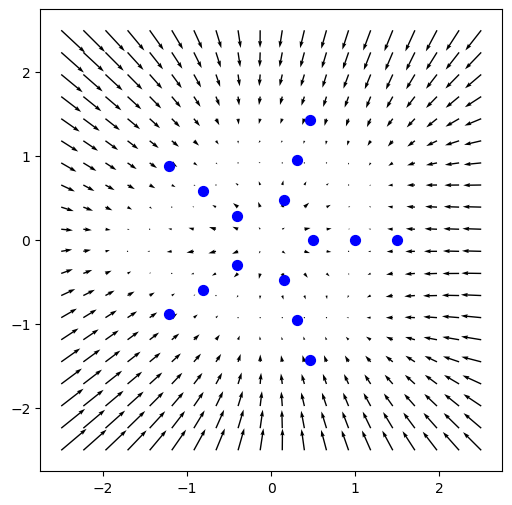

In [27]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 20)
ygrid = np.linspace(-2.5, 2.5, 20)
XX, YY = np.meshgrid(xgrid, ygrid)
U, V = np.zeros_like(XX), np.zeros_like(YY)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = pnts.reshape(-1,2)
mn = model(torch.tensor(pnts_tsr, dtype=torch.float32).cuda()).detach().cpu().numpy()
U = mn[:,0].reshape(20,20)
V = mn[:,1].reshape(20,20)
plt.figure(figsize=(6,6))
plt.quiver(XX, YY, U, V)
# plot the 
plt.scatter(inputs[:,0],inputs[:,1], c='blue', marker='o', s=50)
plt.axis("image")
plt.show()


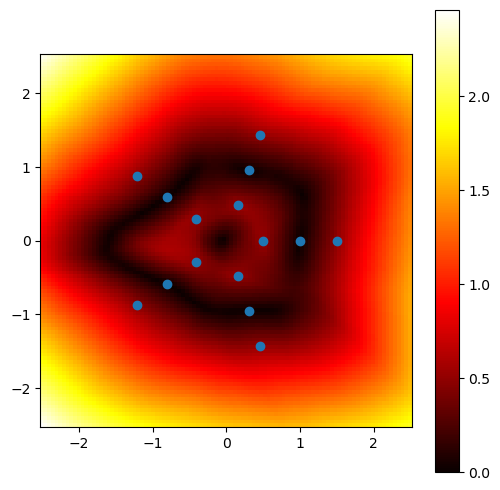

In [33]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 100)
ygrid = np.linspace(-2.5, 2.5, 100)
XX, YY = np.meshgrid(xgrid, ygrid)
U, V = np.zeros_like(XX), np.zeros_like(YY)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = pnts.reshape(-1,2)
mn = model(torch.tensor(pnts_tsr, dtype=torch.float32).cuda()).detach().cpu().numpy()
U = mn[:,0].reshape(XX.shape)
V = mn[:,1].reshape(XX.shape)
plt.figure(figsize=(6,6))
# image heatmap 
plt.pcolor(XX, YY, np.sqrt(U**2 + V**2), cmap='hot', vmin=0)
plt.colorbar()
# plot the 
plt.scatter(inputs[:,0],inputs[:,1])
plt.axis("image")
plt.show()

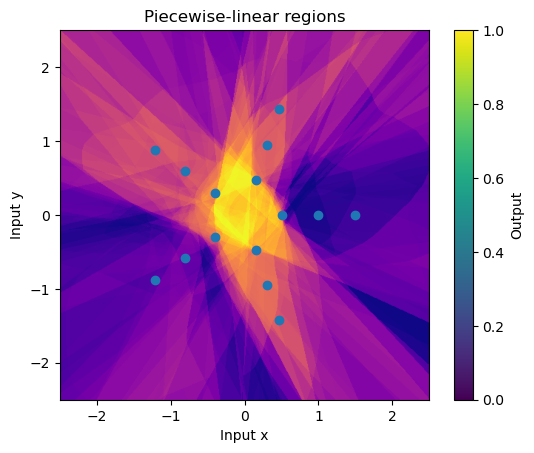

In [29]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 500)
ygrid = np.linspace(-2.5, 2.5, 500)
XX, YY = np.meshgrid(xgrid, ygrid)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = torch.tensor(pnts.reshape(-1,2)).float().cuda()
pnts_tsr.requires_grad = True
model.eval().cuda()
mn = model(pnts_tsr)
mn.sum().backward()
pnts_grad = pnts_tsr.grad.cpu().detach().numpy()

# Find the unique gradient values and assign a color to each unique value
unique_grads, unique_indices = np.unique(pnts_grad, axis=0, return_inverse=True)
colors = np.array([np.arange(len(unique_grads)),] * len(pnts_grad)).flatten()[unique_indices]
colors_grid = colors.reshape(XX.shape)

# Normalize the colors to [0, 1] range
normalized_colors = (colors_grid - colors_grid.min()) / (colors_grid.max() - colors_grid.min())
# Apply Gaussian blur to smooth the edges between regions
# smooth_colors = gaussian_filter(normalized_colors, sigma=1)
plt.imshow(normalized_colors, extent=(-2.5, 2.5, -2.5, 2.5), origin='lower', cmap='plasma')
plt.scatter(inputs[:,0],inputs[:,1])
plt.colorbar(label='Output')
plt.xlabel('Input x')
plt.ylabel('Input y')
plt.title('Piecewise-linear regions')
plt.show()

In [34]:
from torchdiffeq import odeint
import torch

model.eval().to('cuda')
dynamics_system = lambda t, x: model(x)
# Time span for the simulation
t_span = torch.linspace(0, 100, 500).to("cuda")  # torch version of np.linspace
# generate random initial conditions
n_points = 1000
x0 = torch.randn(n_points, 2).to('cuda')
with torch.no_grad():
    solution_tsr = odeint(dynamics_system, x0, t_span, method='dopri5').cpu() # dopri5
print(solution_tsr.shape)
solution_tsr = solution_tsr.permute(1,2,0) # batch, dim, time

torch.Size([500, 1000, 2])


(-4.346096658706665, 3.043723726272583, -3.524825358390808, 3.796180510520935)

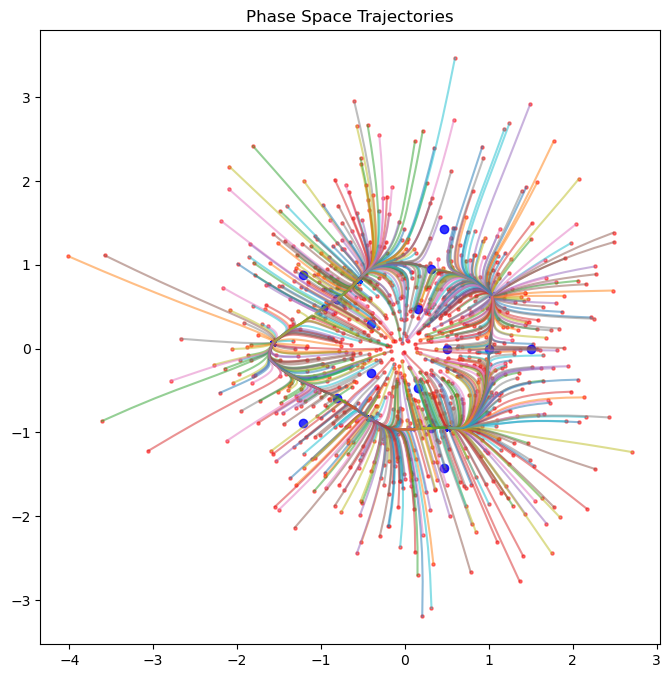

In [35]:
# Plotting the dynamics of the system
plt.figure(figsize=(8, 8))
# for i in range(0,n_points,2):
#     plt.plot(solution_tsr[i, 0], solution_tsr[i, 1], alpha=0.5)
plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5)
plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=5, marker='o', alpha=0.5)
plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
plt.scatter(inputs[:, 0], inputs[:, 1], c='blue', marker='o', alpha=0.8)
plt.title('Phase Space Trajectories')
plt.axis('image')
# piece-wise linear dynamic system vector field.

KeyboardInterrupt: 

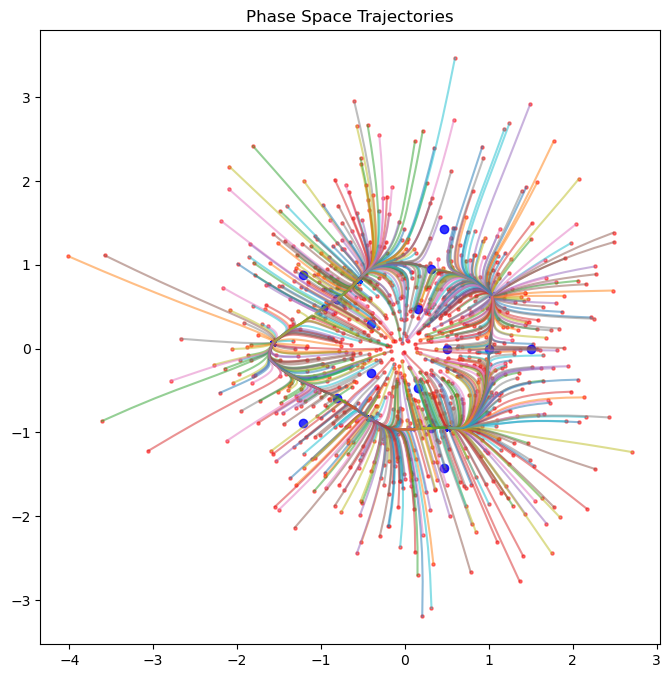

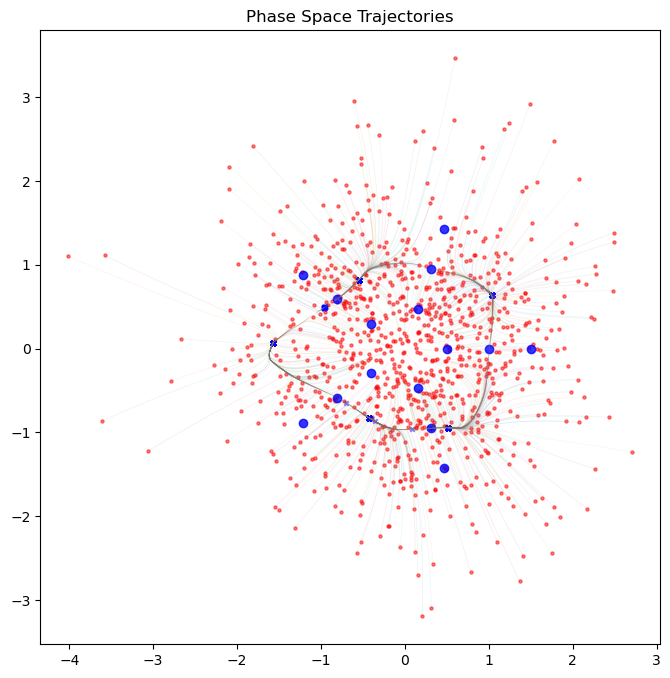

In [37]:
# Plotting the dynamics of the system
plt.figure(figsize=(8, 8))
# for i in range(0,n_points,2):
#     plt.plot(solution_tsr[i, 0], solution_tsr[i, 1], alpha=0.5)
plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5)
plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=5, marker='o', alpha=0.5)
plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
plt.scatter(inputs[:, 0], inputs[:, 1], c='blue', marker='o', alpha=0.8)
plt.title('Phase Space Trajectories')
plt.axis('image')
import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Initialize the scatter plot
scatter = ax.scatter([], [], c='blue', marker='o', alpha=0.8)

# Set the axis limits
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')

# Define the update function for the animation
def update(frame):
    # Clear the previous frame
    ax.clear()
    
    # Plot the phase space trajectories
    ax.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.1, lw=0.5)
    
    # Plot the current frame
    ax.scatter(solution_tsr[:, 0, frame], solution_tsr[:, 1, frame], c='r', s=5, marker='o', alpha=0.5)
    ax.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
    ax.scatter(inputs[:, 0], inputs[:, 1], c='blue', marker='o', alpha=0.8)
    ax.set_title('Phase Space Trajectories')
    ax.set_aspect('equal')

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=solution_tsr.shape[2], interval=100)

# Save the animation as a GIF
ani.save('particle_dynamics.gif', writer='pillow')
# piece-wise linear dynamic system vector field.

### Conditional manifold generation

In [11]:
# Generate the dataset
n_points = 500
a, b = 1, 1  # Semi-axes lengths for the ellipsoid
inputs_all = []
targets_all = []
cond_all = []
theta_list = np.linspace(0, 2 * np.pi, 37)[:-1]
for theta in theta_list:
    for a in [0.5, 1, 1.5, 2.0]:
        # Generate the dataset
        inputs, targets = generate_ellipsoid_dataset_3_rings(n_points, a, b, theta=theta, repeat_endpoint=False)
        # a, cos theta, sin theta
        cond = torch.tensor([a, np.cos(theta), np.sin(theta)]).repeat(3 * n_points, 1)
        inputs_all.append(inputs)
        targets_all.append(targets)
        cond_all.append(cond)
inputs_all = torch.cat(inputs_all, dim=0)
targets_all = torch.cat(targets_all, dim=0)
cond_all = torch.cat(cond_all, dim=0)

In [12]:
print(inputs_all.shape, targets_all.shape, cond_all.shape)

torch.Size([216000, 2]) torch.Size([216000, 2]) torch.Size([216000, 3])


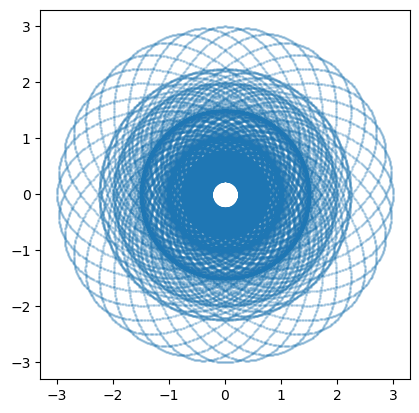

In [15]:
plt.scatter(inputs_all[:,0], inputs_all[:,1],s=1, alpha=0.1)
plt.axis("image")
plt.show()

In [6]:
from torch.utils.data import TensorDataset, DataLoader
# Define the network, loss function, and optimizer
criterion = nn.MSELoss()
# Recreate the model with the corrected class
# model = TwoLayerNN(input_dim=2, hidden_dim=50, output_dim=2)
# model = MLP_general(input_dim=5, hidden_dims=[256,256,256,256,256,], output_dim=2, activation_fun=nn.ReLU)
# model = MLP_general(input_dim=5, hidden_dims=[256,256,256,256,256,], output_dim=2, activation_fun=nn.ReLU)
model = MLP_general(input_dim=5, hidden_dims=[512,512,512,512,512,], output_dim=2, activation_fun=nn.ReLU)
model.train().cuda()
# Redefine the optimizer because the model parameters have changed
optimizer = optim.Adam(model.parameters(), lr=0.001)
inpcond_all = torch.cat([inputs_all, cond_all], dim=1).cuda().float()
targets_all = targets_all.cuda().float()
# dataset = TensorDataset(inputs_all.cuda().float(), targets_all.cuda().float(), cond_all.cuda().float())
# dataloader = DataLoader(dataset, batch_size=60000, shuffle=False)
epochs = 1000
# Retrain the model with the corrected architecture
for epoch in range(epochs):
    optimizer.zero_grad()
    # for inputs, targets, cond in dataloader:
    outputs = model(inpcond_all)
    loss = criterion(outputs, targets_all)
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

final_loss = loss.item()
final_loss

Epoch 0/1000, Loss: 0.12035568058490753
Epoch 25/1000, Loss: 0.016626011580228806
Epoch 50/1000, Loss: 0.007375645451247692
Epoch 75/1000, Loss: 0.0023250188678503036
Epoch 100/1000, Loss: 0.003735488746315241
Epoch 125/1000, Loss: 0.0006535672582685947
Epoch 150/1000, Loss: 0.00043438078137114644
Epoch 175/1000, Loss: 0.00042855707579292357
Epoch 200/1000, Loss: 0.0002185115881729871
Epoch 225/1000, Loss: 0.00014977730461396277
Epoch 250/1000, Loss: 0.00010913583537330851
Epoch 275/1000, Loss: 8.959863771451637e-05
Epoch 300/1000, Loss: 7.490724965464324e-05
Epoch 325/1000, Loss: 0.0001265640603378415
Epoch 350/1000, Loss: 6.057244536350481e-05
Epoch 375/1000, Loss: 0.000515982392244041
Epoch 400/1000, Loss: 5.180730659049004e-05
Epoch 425/1000, Loss: 0.0010604043491184711
Epoch 450/1000, Loss: 9.39699966693297e-05
Epoch 475/1000, Loss: 3.830572313745506e-05
Epoch 500/1000, Loss: 2.8244598070159554e-05
Epoch 525/1000, Loss: 2.427100480417721e-05
Epoch 550/1000, Loss: 0.000297850288916

0.00014713792188558728

In [7]:
torch.save(model.state_dict(), 'cond_rnn_mlp_d5_w512.pth')

In [17]:
from torchdiffeq import odeint
import torch

In [63]:
model.eval().to('cuda')
dynamics_system = lambda t, x: model(torch.cat([x, cond_eval], dim=1))
# Time span for the simulation
t_span = torch.linspace(0, 100, 500).to("cuda")  # torch version of np.linspace
# generate random initial conditions
n_points = 1000
a_eval = 0.5
theta_eval = np.pi/6
cond_eval = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).repeat(n_points, 1)\
    .float().cuda()
x0 = torch.randn(n_points, 2).to('cuda')
with torch.no_grad():
    solution_tsr = odeint(dynamics_system, x0, t_span, method='dopri5').cpu() # dopri5
print(solution_tsr.shape)
solution_tsr = solution_tsr.permute(1, 2, 0) # batch, dim, time

torch.Size([500, 1000, 2])


(-3.4675740957260133,
 3.812025046348572,
 -3.7874218463897704,
 3.095066213607788)

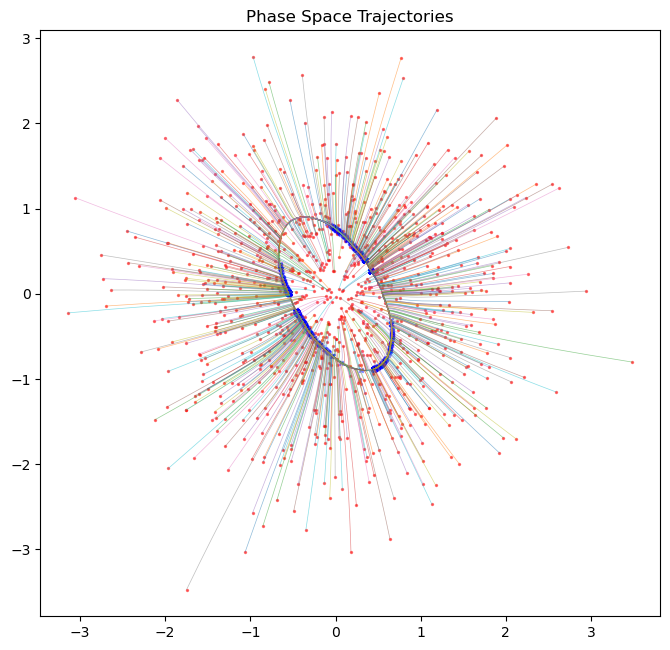

In [64]:
ellips = generate_ellipsoid_orbit(100, a_eval, b, theta=theta_eval)
# Plotting the dynamics of the system
plt.figure(figsize=(8, 8))
plt.plot(ellips[:, 0], ellips[:, 1], c='green', lw=1, alpha=0.5)   
plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5, lw=0.5)
plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=2, marker='o', alpha=0.5)
plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
plt.title('Phase Space Trajectories')
plt.axis('image')

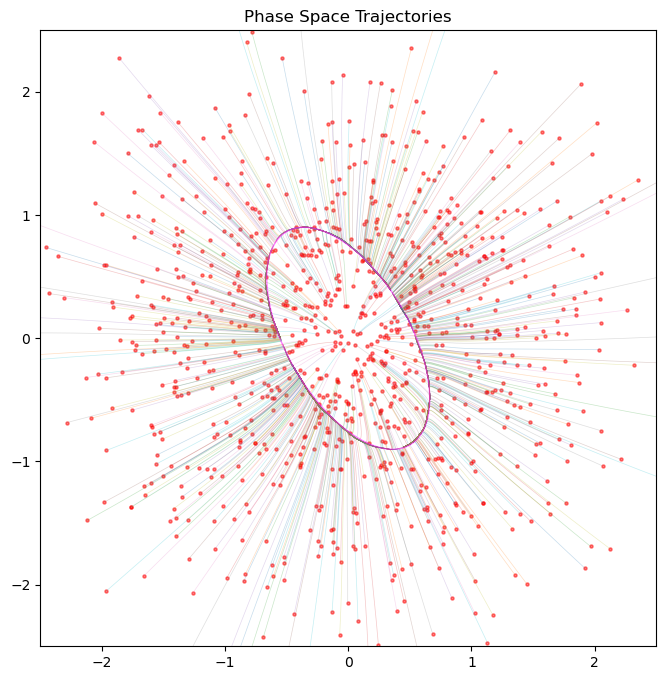

In [70]:

import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

traj_collection = ax.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.25, lw=0.5)
# Initialize the scatter plot for dynamic updates
scatter_dynamic = ax.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=5, marker='o', alpha=0.5)
# Initialize a scatter plot for static points
scatter_static = ax.plot(ellips[:, 0], ellips[:, 1], c='magenta', lw=1, alpha=0.5)   

# Set the axis limits and aspect ratio
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')
ax.set_title('Phase Space Trajectories')
# Set the axis limits

# Define the update function for the animation
def update(frame):
    # Update positions of the dynamic scatter plot
    scatter_dynamic.set_offsets(np.c_[solution_tsr[:, 0, frame], solution_tsr[:, 1, frame]])
    # Note: No need to clear the axes or re-draw static elements

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=solution_tsr.shape[2], interval=100)

# Save the animation as a GIF
# ani.save('particle_dynamics_dense_cond.gif', writer='pillow')
# ani.save('particle_dynamics_dense_cond.gif', writer='pillow')
# piece-wise linear dynamic system vector field.

In [75]:
ani.save('particle_dynamics_dense_cond.gif', writer='ffmpeg')

In [74]:
ani.save('particle_dynamics_dense_cond.mp4', writer='ffmpeg')

### Massive export of dynamics videos

In [76]:
from matplotlib.animation import FFMpegWriter

writer = FFMpegWriter(fps=25, codec='libx264', extra_args=['-preset', 'fast', '-crf', '25'])
ani.save('tmp.mp4', writer=writer)

In [12]:
# use agg backend to render the animation
import matplotlib
matplotlib.use('agg')

In [13]:
from torchdiffeq import odeint
import torch
import matplotlib.animation as animation
from os.path import join
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/HaimDiffusionRNNProj/StarShapeRNN_demo"
model.eval().to('cuda')
# Time span for the simulation
t_span = torch.linspace(0, 100, 200).to("cuda")  # torch version of np.linspace
# generate random initial conditions
n_points = 1000
x0 = torch.randn(n_points, 2).to('cuda')
# a_eval = 0.5
# theta_eval = np.pi/6
for a_eval in [0.5, 1, 1.5, 2.0]:
    for theta_eval in np.linspace(0, 2 * np.pi, 13)[:-1]:
        cond_eval = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).repeat(n_points, 1)\
            .float().cuda()
        dynamics_system = lambda t, x: model(torch.cat([x, cond_eval], dim=1))
        with torch.no_grad():
            solution_tsr = odeint(dynamics_system, x0, t_span, method='dopri5').cpu() # dopri5
        print(solution_tsr.shape)
        solution_tsr = solution_tsr.permute(1, 2, 0) # batch, dim, time

        ellips = generate_ellipsoid_orbit(100, a_eval, b=1, theta=theta_eval)
        # Plotting the dynamics of the system
        plt.figure(figsize=(8, 8))
        plt.plot(ellips[:, 0], ellips[:, 1], c='green', lw=1, alpha=0.5)   
        plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5, lw=0.5)
        plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=2, marker='o', alpha=0.5)
        plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
        plt.title('Phase Space Trajectories, a = %.2f, theta=%.2f pi' % (a_eval, theta_eval / np.pi))
        plt.axis('image')
        plt.savefig(join(figdir,f'particle_dynamics_ellips_dense_cond_A{a_eval}_theta{theta_eval / np.pi:.02f}pi.png'))
        plt.show()
        
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(8, 8))
        traj_collection = ax.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.25, lw=0.5)
        # Initialize the scatter plot for dynamic updates
        scatter_dynamic = ax.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=5, marker='o', alpha=0.5)
        # Initialize a scatter plot for static points
        scatter_static = ax.plot(ellips[:, 0], ellips[:, 1], c='magenta', lw=1, alpha=0.5)   
        # Set the axis limits and aspect ratio
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_aspect('equal')
        ax.set_title('Phase Space Trajectories')
        # Set the axis limits
        # Define the update function for the animation
        def update(frame):
            # Update positions of the dynamic scatter plot
            scatter_dynamic.set_offsets(np.c_[solution_tsr[:, 0, frame], solution_tsr[:, 1, frame]])
            ax.set_title('Phase Space Trajectories, a = %.2f, theta=%.2f pi [%d]' % (a_eval, theta_eval / np.pi, frame))
            # Note: No need to clear the axes or re-draw static elements
        # Create the animation
        ani = animation.FuncAnimation(fig, update, frames=solution_tsr.shape[2], interval=100)
        ani.save(join(figdir,f'particle_dynamics_ellips_dense_cond_A{a_eval}_theta{theta_eval / np.pi:.02f}pi.gif'), writer='ffmpeg')
        # raise ValueError('Stop here')

torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])


/tmp/ipykernel_3043005/3938316999.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])
torch.Size([200, 1000, 2])


### Context switching for attractor

In [19]:
model = MLP_general(input_dim=5, hidden_dims=[512,512,512,512,512,], output_dim=2, activation_fun=nn.ReLU)
model.load_state_dict(torch.load('cond_rnn_mlp_d5_w512.pth'))

<All keys matched successfully>

In [ ]:
cond_eval1 = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).\
    expand(n_points, -1).float().cuda()

torch.Size([500, 1000, 2])


(-3.0943809509277345,
 3.6759844779968263,
 -3.8760116577148436,
 3.9025500297546385)

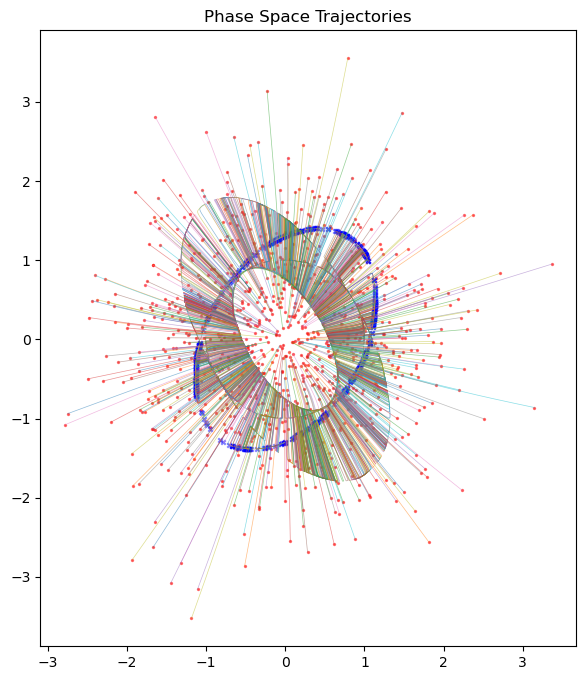

In [22]:
import numpy as np
model.eval().to('cuda')
# Time span for the simulation
t_span = torch.linspace(0, 100, 500).to("cuda")  # torch version of np.linspace
# generate random initial conditions
n_points = 1000
a_eval = 0.5
theta_eval = np.pi/6
    

def get_a_theta(t):
    if t < 25:
        a_eval = 0.5
        theta_eval = np.pi/6
    elif t < 50:
        a_eval = 1
        theta_eval = np.pi/4
    elif t < 75:
        a_eval = 2
        theta_eval = np.pi * 2 / 3 
    else:
        a_eval = 1.5
        theta_eval = np.pi/3
    return a_eval, theta_eval

def cond_tsr_t(t):
    a_eval, theta_eval = get_a_theta(t)
    cond_eval = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).\
        expand(n_points, -1).float().cuda()
    return cond_eval

dynamics_system_t = lambda t, x: model(torch.cat([x, cond_tsr_t(t)], dim=1))
# dynamics_system = lambda t, x: model(torch.cat([x, cond_eval], dim=1))
x0 = torch.randn(n_points, 2).to('cuda')
with torch.no_grad():
    solution_tsr = odeint(dynamics_system_t, x0, t_span, method='dopri5').cpu() # dopri5
print(solution_tsr.shape)
solution_tsr = solution_tsr.permute(1, 2, 0) # batch, dim, time
# cond_eval1 = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).\
#     repeat(n_points, 1).float().cuda()
ellips = generate_ellipsoid_orbit(100, a_eval, b, theta=theta_eval)
# Plotting the dynamics of the system
plt.figure(figsize=(8, 8))
plt.plot(ellips[:, 0], ellips[:, 1], c='green', lw=1, alpha=0.5)   
plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5, lw=0.5)
plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=2, marker='o', alpha=0.5)
plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
plt.title('Phase Space Trajectories')
plt.axis('image')

In [24]:
%matplotlib ipympl

In [32]:
a_eval, theta_eval = get_a_theta(t_span[140].item())
a_eval, theta_eval

(1, 0.7853981633974483)

In [ ]:

import matplotlib.animation as animation
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
traj_collection = ax.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.25, lw=0.5)
# Initialize the scatter plot for dynamic updates
scatter_dynamic = ax.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=5, marker='o', alpha=0.5)
# Initialize a scatter plot for static points
scatter_static = ax.plot(ellips[:, 0], ellips[:, 1], c='magenta', lw=1, alpha=0.5)   
# Set the axis limits and aspect ratio
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')
ax.set_title('Phase Space Trajectories')
# Set the axis limits
# Define the update function for the animation
def update(frame):
    # Update positions of the dynamic scatter plot
    scatter_dynamic.set_offsets(np.c_[solution_tsr[:, 0, frame], solution_tsr[:, 1, frame]])
    a_eval, theta_eval = get_a_theta(t_span[frame].item())
    ellips = generate_ellipsoid_orbit(100, a_eval, b, theta=theta_eval)
    scatter_static[0].set_data(ellips[:, 0], ellips[:, 1])
    ax.set_title('Phase Space Trajectories, a = %.2f, theta=%.2f pi [%d]' % (a_eval, theta_eval / np.pi, frame))
    # Note: No need to clear the axes or re-draw static elements
# Create the animation
ani = animation.FuncAnimation(fig, update, frames=solution_tsr.shape[2], interval=100)

plt.show()

In [38]:
ani.save(f'particle_dynamics_ellips_dense_context_switching.gif', writer='ffmpeg')

In [39]:
ani.save(f'particle_dynamics_ellips_dense_context_switching.mp4', writer='ffmpeg')

In [36]:
scatter_static[0].set_data

In [ ]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 20)
ygrid = np.linspace(-2.5, 2.5, 20)
XX, YY = np.meshgrid(xgrid, ygrid)
U, V = np.zeros_like(XX), np.zeros_like(YY)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = pnts.reshape(-1,2)
mn = model(torch.tensor(pnts_tsr, dtype=torch.float32).cuda()).detach().cpu().numpy()
U = mn[:,0].reshape(20,20)
V = mn[:,1].reshape(20,20)
plt.figure(figsize=(6,6))
plt.quiver(XX, YY, U, V)
# plot the 
plt.scatter(inputs[:,0],inputs[:,1], c='blue', marker='o', s=50)
plt.axis("image")
plt.show()


In [ ]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 100)
ygrid = np.linspace(-2.5, 2.5, 100)
XX, YY = np.meshgrid(xgrid, ygrid)
U, V = np.zeros_like(XX), np.zeros_like(YY)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = pnts.reshape(-1,2)
mn = model(torch.tensor(pnts_tsr, dtype=torch.float32).cuda()).detach().cpu().numpy()
U = mn[:,0].reshape(XX.shape)
V = mn[:,1].reshape(XX.shape)
plt.figure(figsize=(6,6))
# image heatmap 
plt.pcolor(XX, YY, np.sqrt(U**2 + V**2), cmap='hot', vmin=0)
plt.colorbar()
# plot the 
plt.scatter(inputs[:,0],inputs[:,1])
plt.axis("image")
plt.show()

In [ ]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 500)
ygrid = np.linspace(-2.5, 2.5, 500)
XX, YY = np.meshgrid(xgrid, ygrid)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = torch.tensor(pnts.reshape(-1,2)).float().cuda()
pnts_tsr.requires_grad = True
model.eval().cuda()
mn = model(pnts_tsr)
mn.sum().backward()
pnts_grad = pnts_tsr.grad.cpu().detach().numpy()

# Find the unique gradient values and assign a color to each unique value
unique_grads, unique_indices = np.unique(pnts_grad, axis=0, return_inverse=True)
colors = np.array([np.arange(len(unique_grads)),] * len(pnts_grad)).flatten()[unique_indices]
colors_grid = colors.reshape(XX.shape)

# Normalize the colors to [0, 1] range
normalized_colors = (colors_grid - colors_grid.min()) / (colors_grid.max() - colors_grid.min())
# Apply Gaussian blur to smooth the edges between regions
# smooth_colors = gaussian_filter(normalized_colors, sigma=1)
plt.imshow(normalized_colors, extent=(-2.5, 2.5, -2.5, 2.5), origin='lower', cmap='plasma')
plt.scatter(inputs[:,0],inputs[:,1])
plt.colorbar(label='Output')
plt.xlabel('Input x')
plt.ylabel('Input y')
plt.title('Piecewise-linear regions')
plt.show()

### Dense sampling

In [5]:
# Generate the dataset
a, b = 1, 1  # Semi-axes lengths for the ellipsoid
n_points = 500
inputs, targets = generate_ellipsoid_dataset(n_points, a, b, noise=0.0)
# Define the network, loss function, and optimizer
criterion = nn.MSELoss()
# Recreate the model with the corrected class
# model = TwoLayerNN(input_dim=2, hidden_dim=50, output_dim=2)
model = MLP_general(input_dim=2, hidden_dims=[30,30,30], output_dim=2)
model = MLP_general(input_dim=2, hidden_dims=[50,50,50], output_dim=2)
# Redefine the optimizer because the model parameters have changed
model.train().cuda()
inputs = inputs.cuda()
targets = targets.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
# Retrain the model with the corrected architecture
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(inputs.float())
    loss = criterion(outputs.squeeze(), targets.float())
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

final_loss = loss.item()
final_loss

Epoch 0/1000, Loss: 0.09564967453479767
Epoch 100/1000, Loss: 4.638791142497212e-05
Epoch 200/1000, Loss: 3.2944943086476997e-05
Epoch 300/1000, Loss: 0.00047865710803307593
Epoch 400/1000, Loss: 3.4185654840257484e-06
Epoch 500/1000, Loss: 5.993246759317117e-06
Epoch 600/1000, Loss: 2.075064003292937e-06
Epoch 700/1000, Loss: 3.506555458443472e-06
Epoch 800/1000, Loss: 1.721094463391637e-06
Epoch 900/1000, Loss: 3.263234475525678e-06


1.6496709349667071e-06

In [6]:
inputs = inputs.cpu()
targets = targets.cpu()

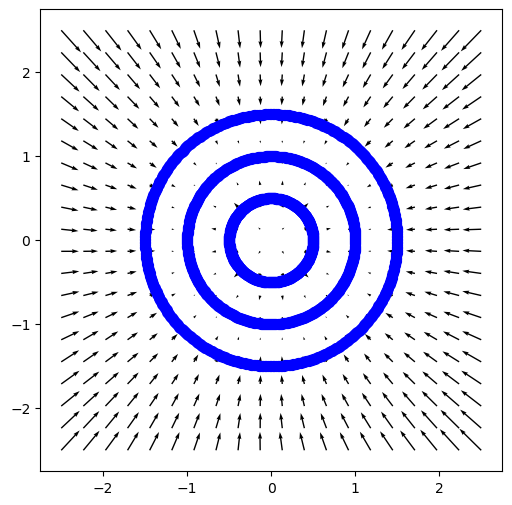

In [7]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 20)
ygrid = np.linspace(-2.5, 2.5, 20)
XX, YY = np.meshgrid(xgrid, ygrid)
U, V = np.zeros_like(XX), np.zeros_like(YY)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = pnts.reshape(-1,2)
mn = model(torch.tensor(pnts_tsr, dtype=torch.float32).cuda()).detach().cpu().numpy()
U = mn[:,0].reshape(20,20)
V = mn[:,1].reshape(20,20)
plt.figure(figsize=(6,6))
plt.quiver(XX, YY, U, V)
# plot the 
plt.scatter(inputs[:,0],inputs[:,1], c='blue', marker='o', s=50)
plt.axis("image")
plt.show()


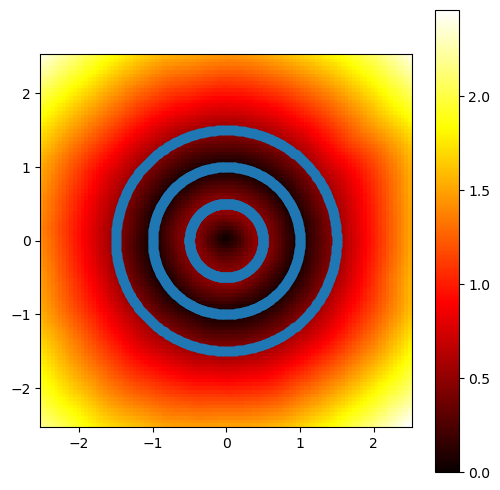

In [8]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 100)
ygrid = np.linspace(-2.5, 2.5, 100)
XX, YY = np.meshgrid(xgrid, ygrid)
U, V = np.zeros_like(XX), np.zeros_like(YY)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = pnts.reshape(-1,2)
mn = model(torch.tensor(pnts_tsr, dtype=torch.float32).cuda()).detach().cpu().numpy()
U = mn[:,0].reshape(XX.shape)
V = mn[:,1].reshape(XX.shape)
plt.figure(figsize=(6,6))
# image heatmap 
plt.pcolor(XX, YY, np.sqrt(U**2 + V**2), cmap='hot', vmin=0)
plt.colorbar()
# plot the 
plt.scatter(inputs[:,0],inputs[:,1])
plt.axis("image")
plt.show()

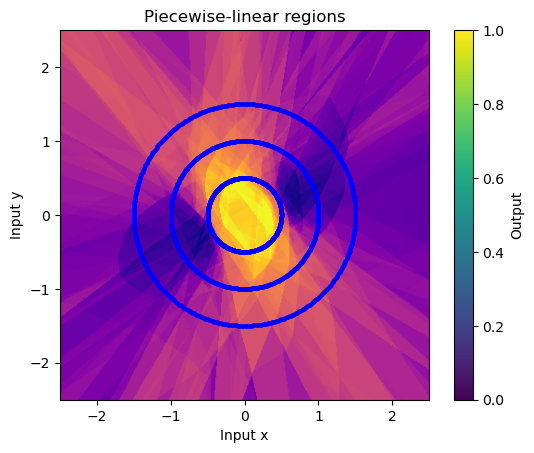

In [11]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 400)
ygrid = np.linspace(-2.5, 2.5, 400)
XX, YY = np.meshgrid(xgrid, ygrid)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = torch.tensor(pnts.reshape(-1,2)).float().cuda()
pnts_tsr.requires_grad = True
model.eval().cuda()
mn = model(pnts_tsr)
mn.sum().backward()
pnts_grad = pnts_tsr.grad.cpu().detach().numpy()

# Find the unique gradient values and assign a color to each unique value
unique_grads, unique_indices = np.unique(pnts_grad, axis=0, return_inverse=True)
colors = np.array([np.arange(len(unique_grads)),] * len(pnts_grad)).flatten()[unique_indices]
colors_grid = colors.reshape(XX.shape)

# Normalize the colors to [0, 1] range
normalized_colors = (colors_grid - colors_grid.min()) / (colors_grid.max() - colors_grid.min())
# Apply Gaussian blur to smooth the edges between regions
# smooth_colors = gaussian_filter(normalized_colors, sigma=1)
plt.imshow(normalized_colors, extent=(-2.5, 2.5, -2.5, 2.5), origin='lower', cmap='plasma')
plt.scatter(inputs[:,0],inputs[:,1], s=5, c='blue', marker='o')
plt.colorbar(label='Output')
plt.xlabel('Input x')
plt.ylabel('Input y')
plt.title('Piecewise-linear regions')
plt.show()

In [12]:
from torchdiffeq import odeint
import torch

model.eval().to('cuda')
dynamics_system = lambda t, x: model(x)
# Time span for the simulation
t_span = torch.linspace(0, 100, 500).to("cuda")  # torch version of np.linspace
# generate random initial conditions
n_points = 1000
x0 = torch.randn(n_points, 2).to('cuda')
with torch.no_grad():
    solution_tsr = odeint(dynamics_system, x0, t_span, method='dopri5').cpu() # dopri5
print(solution_tsr.shape)
solution_tsr = solution_tsr.permute(1,2,0) # batch, dim, time

torch.Size([500, 1000, 2])


(-3.1285955548286437,
 3.4047884583473205,
 -3.4471256494522096,
 3.553926682472229)

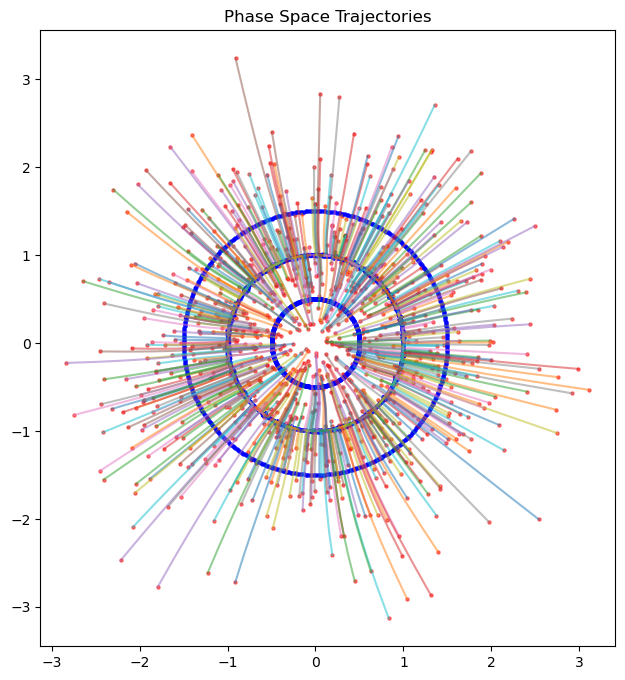

In [13]:
# Plotting the dynamics of the system
plt.figure(figsize=(8, 8))
# for i in range(0,n_points,2):
#     plt.plot(solution_tsr[i, 0], solution_tsr[i, 1], alpha=0.5)
plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5)
plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=5, marker='o', alpha=0.5)
plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
plt.scatter(inputs[:, 0], inputs[:, 1], c='blue', s=5, marker='o', alpha=0.8)
plt.title('Phase Space Trajectories')
plt.axis('image')
# piece-wise linear dynamic system vector field.

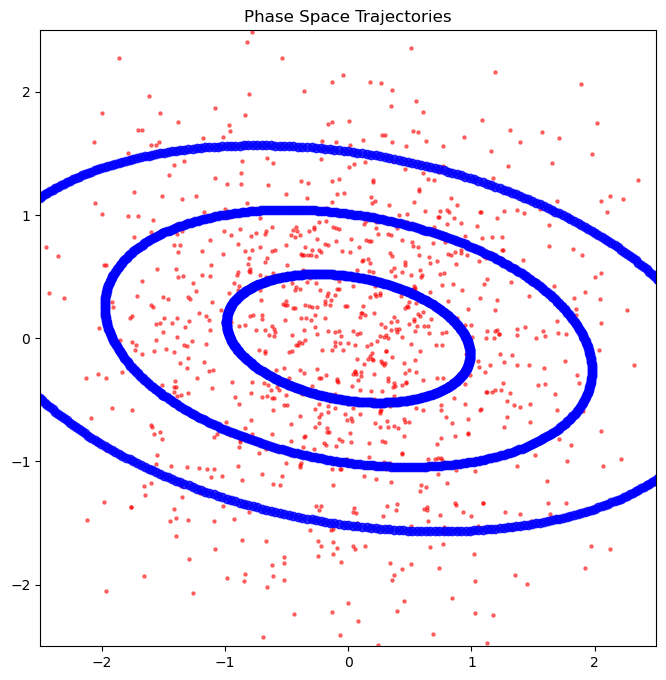

In [65]:

import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Initialize the scatter plot for dynamic updates
scatter_dynamic = ax.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=5, marker='o', alpha=0.5)
# Initialize a scatter plot for static points
scatter_static = ax.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5)

# Set the axis limits and aspect ratio
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')
ax.set_title('Phase Space Trajectories')
# Set the axis limits

# Define the update function for the animation
def update(frame):
    # Update positions of the dynamic scatter plot
    scatter_dynamic.set_offsets(np.c_[solution_tsr[:, 0, frame], solution_tsr[:, 1, frame]])
    # Note: No need to clear the axes or re-draw static elements

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=solution_tsr.shape[2], interval=100)

# Save the animation as a GIF
# ani.save('particle_dynamics_dense_cond.gif', writer='pillow')
ani.save('particle_dynamics_dense_cond.gif', writer='pillow')
# piece-wise linear dynamic system vector field.

In [66]:
from IPython.display import HTML

# Assuming 'ani' is your animation object
HTML(ani.to_html5_video())

MovieWriter stderr:
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '800x800', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpfii72xem/temp.m4v']' returned non-zero exit status 127.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Assuming solution_tsr and inputs are defined somewhere in your code.
# solution_tsr is a tensor of shape (N, 2, T) where N is the number of particles,
# 2 for x and y coordinates, and T is the number of time steps.
# inputs is an array of initial positions of shape (N, 2).

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
plt.ioff()  # Turn interactive plotting off
# Plot the phase space trajectories
# ax.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.2, lw=1.0)

frames = []  # List to hold generated frames

# Define the update function to draw each frame
def update(frame):
    # Clear the previous frame
    ax.clear()
    # Plot the current frame
    ax.scatter(solution_tsr[:, 0, frame], solution_tsr[:, 1, frame], c='r', s=5, marker='o', alpha=0.5)
    ax.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
    ax.scatter(inputs[:, 0], inputs[:, 1], c='blue', marker='o', alpha=0.8)
    ax.set_title('Phase Space Trajectories')
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    # Instead of displaying, save each frame to the buffer
    fig.canvas.draw()       # Draw the figure
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

# Generate each frame and add it to the list
for frame in range(solution_tsr.shape[2]):
    img = update(frame)
    frames.append(img)

# Save the frames as an mp4
imageio.mimsave('particle_dynamics_dense.mp4', frames, fps=10)

RuntimeError: No ffmpeg exe could be found. Install ffmpeg on your system, or set the IMAGEIO_FFMPEG_EXE environment variable.

In [ ]:

from tqdm import trange
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def dynamics_system(t, x, model):
    """
    Defines the dynamics of the system: dx/dt = -x + mlp(x).
    
    Parameters:
    - t: The time variable (not used in the equation but required by solve_ivp).
    - x: The state vector of the system.
    - model: The trained PyTorch model.
    
    Returns:
    - The derivative of x with respect to time.
    """
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add batch dimension
    mlp_output = model(x_tensor).squeeze().detach().numpy()  # Get MLP output and convert back to numpy
    dxdt =  mlp_output # 
    return dxdt

# Time span for the simulation
t_span = [0, 100]
t_eval = np.linspace(*t_span, 500)
# generate random initial conditions
n_points = 500
x0 = torch.randn(n_points, 2)
# solve the system for each initial condition
solutions = []
for i in trange(n_points):
    solution = solve_ivp(dynamics_system, t_span, x0[i], args=(model,), t_eval=t_eval, method='RK45')
    solutions.append(solution.y)
solution_tsr = torch.tensor(solutions)


100%|██████████| 500/500 [00:13<00:00, 36.89it/s]
/tmp/ipykernel_2632856/1107587692.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/torch/csrc/utils/tensor_new.cpp:245.)
  solution_tsr = torch.tensor(solutions)


In [ ]:
from torchdiffeq import odeint
import torch

# Time span for the simulation
t_span = torch.linspace(0, 100, 500)  # torch version of np.linspace
# generate random initial conditions
n_points = 500
x0 = torch.randn(n_points, 2).to('cuda')
# solve the system for each initial condition
solutions = []
model.eval().to('cuda')
dynamics_system = lambda t, x: model(x)
for i in trange(n_points):
    solution = odeint(dynamics_system, x0[i], t_span, method='rk4') # dopri5
    solutions.append(solution)
solution_tsr = torch.stack(solutions)


  0%|          | 0/500 [00:00<?, ?it/s]/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
100%|██████████| 500/500 [04:17<00:00,  1.94it/s]


In [ ]:
solution_s = odeint(dynamics_system, x0, t_span, method='dopri5') # dopri5

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


### Scratch files

In [15]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Initialize the first layer weights and biases
        thetas = torch.linspace(0, 2 * np.pi, hidden_dim)
        init_weights = torch.stack((torch.cos(thetas), torch.sin(thetas)), dim=1)  # Corrected shape
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc1.weight = nn.Parameter(init_weights)
        self.fc1.bias = nn.Parameter(torch.zeros(hidden_dim))
        
        # Initialize the second layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def generate_ellipsoid_dataset(n_points, a, b, noise=0.1):
    """
    Generate a dataset of points on an ellipsoid centered at the origin.
    
    Parameters:
    - n_points: Number of points to generate.
    - a, b: Semi-major and semi-minor axes of the ellipsoid.
    - noise: Standard deviation of Gaussian noise to be added to the ellipsoid values.
    
    Returns:
    - A tuple of tensors (inputs, targets), where inputs are the coordinates of the points,
      and targets are the ellipsoid values (ideally close to 1, with some noise).
    """
    angles = torch.linspace(0, 2 * np.pi, n_points)
    x = a * torch.cos(angles) + torch.randn(n_points) * noise
    y = b * torch.sin(angles) + torch.randn(n_points) * noise
    inputs = torch.stack([x, y], dim=1)
    # targets = torch.ones(n_points,2) + torch.randn(n_points,2) * noise
    targets = inputs  + torch.randn(n_points,2) * noise # torch.zeros(n_points,2)
    return inputs, targets

#%%
# Generate the dataset
a, b = 1, 1  # Semi-axes lengths for the ellipsoid
n_points = 1000
inputs, targets = generate_ellipsoid_dataset(n_points, a, b, noise=0.0)
# Define the network, loss function, and optimizer
criterion = nn.MSELoss()
# Recreate the model with the corrected class
model = TwoLayerNN(input_dim=2, hidden_dim=500, output_dim=2)
# Redefine the optimizer because the model parameters have changed
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
# Retrain the model with the corrected architecture
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(inputs.float())
    loss = criterion(outputs.squeeze(), targets.float())
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

final_loss = loss.item()
final_loss

Epoch 0/1000, Loss: 0.5211310386657715
Epoch 100/1000, Loss: 1.971819256141316e-05
Epoch 200/1000, Loss: 1.546549356135074e-05
Epoch 300/1000, Loss: 1.9828123186016455e-05
Epoch 400/1000, Loss: 6.409014531527646e-06
Epoch 500/1000, Loss: 3.5354503779672086e-05
Epoch 600/1000, Loss: 2.411188506812323e-05
Epoch 700/1000, Loss: 0.00015670353604946285
Epoch 800/1000, Loss: 1.322801722380973e-06
Epoch 900/1000, Loss: 1.866837237685104e-06


5.3070551075506955e-05

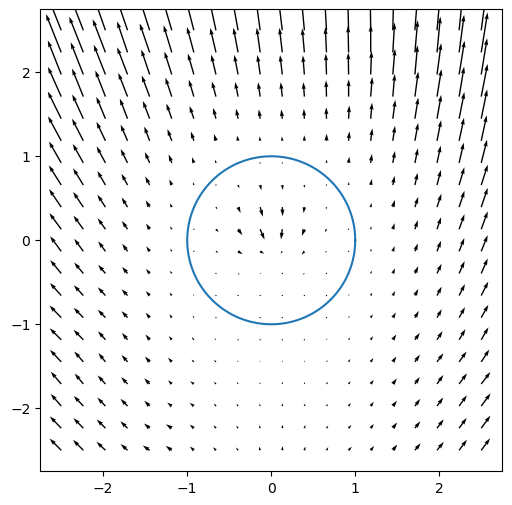

In [16]:
# plot the dynmic system as vector field.
xgrid = np.linspace(-2.5, 2.5, 20)
ygrid = np.linspace(-2.5, 2.5, 20)
XX, YY = np.meshgrid(xgrid, ygrid)
U, V = np.zeros_like(XX), np.zeros_like(YY)
pnts = np.stack([XX, YY], axis=-1)
pnts_tsr = pnts.reshape(-1,2)
mn = model(torch.tensor(pnts_tsr, dtype=torch.float32)).detach().numpy()
U = mn[:,0].reshape(20,20)
V = mn[:,1].reshape(20,20)
plt.figure(figsize=(6,6))
plt.quiver(XX, YY, U - XX, V - YY)
# plot the 
plt.plot(inputs[:,0],inputs[:,1])
plt.axis("image")
plt.show()


In [17]:

class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Initialize the first layer weights and biases
        thetas = torch.linspace(0, 2 * np.pi, hidden_dim)
        init_weights = torch.stack((torch.cos(thetas), torch.sin(thetas)), dim=1)  # Corrected shape
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc1.weight = nn.Parameter(init_weights)
        self.fc1.bias = nn.Parameter(torch.zeros(hidden_dim))
        self.fc1.requires_grad = False
        # Initialize the second layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def generate_ellipsoid_dataset(n_points, a, b, noise=0.1):
    """
    Generate a dataset of points on an ellipsoid centered at the origin.
    
    Parameters:
    - n_points: Number of points to generate.
    - a, b: Semi-major and semi-minor axes of the ellipsoid.
    - noise: Standard deviation of Gaussian noise to be added to the ellipsoid values.
    
    Returns:
    - A tuple of tensors (inputs, targets), where inputs are the coordinates of the points,
      and targets are the ellipsoid values (ideally close to 1, with some noise).
    """
    angles = torch.linspace(0, 2 * np.pi, n_points)
    x = a * torch.cos(angles) + torch.randn(n_points) * noise
    y = b * torch.sin(angles) + torch.randn(n_points) * noise
    inputs = torch.stack([x, y], dim=1)
    # targets = torch.ones(n_points,2) + torch.randn(n_points,2) * noise
    targets = inputs  + torch.randn(n_points,2) * noise # torch.zeros(n_points,2)
    return inputs, targets

# Generate the dataset
a, b = 1, 1  # Semi-axes lengths for the ellipsoid
n_points = 1000
inputs, targets = generate_ellipsoid_dataset(n_points, a, b, noise=0.0)
# Define the network, loss function, and optimizer
criterion = nn.MSELoss()
# Recreate the model with the corrected class
model = TwoLayerNN(input_dim=2, hidden_dim=500, output_dim=2)
# Redefine the optimizer because the model parameters have changed
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
# Retrain the model with the corrected architecture
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(inputs.float())
    loss = criterion(outputs.squeeze(), targets.float())
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

final_loss = loss.item()
final_loss

Epoch 0/1000, Loss: 0.8566941022872925
Epoch 100/1000, Loss: 2.098233744618483e-05
Epoch 200/1000, Loss: 6.968199159018695e-06
Epoch 300/1000, Loss: 4.382388397061732e-06
Epoch 400/1000, Loss: 5.87286513109575e-06
Epoch 500/1000, Loss: 0.00048273499123752117
Epoch 600/1000, Loss: 7.442574133165181e-05
Epoch 700/1000, Loss: 0.00012327145668677986
Epoch 800/1000, Loss: 0.0029755933210253716
Epoch 900/1000, Loss: 9.03412092156941e-06


7.649709732504562e-05

100%|██████████| 500/500 [00:02<00:00, 220.12it/s]


(-2.3580518841743467,
 2.4185365319252012,
 -2.6592157661914824,
 2.188586193323135)

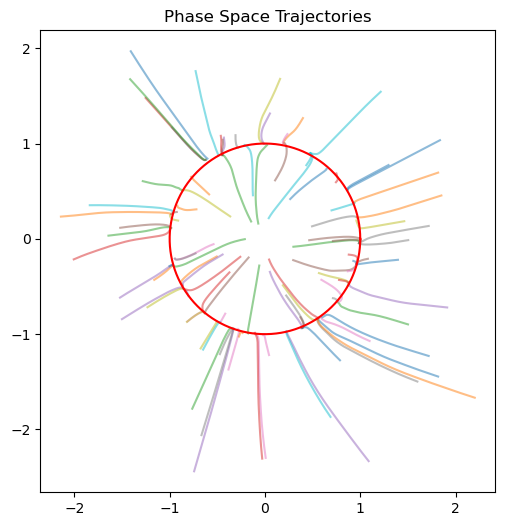

In [10]:

#%%
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def dynamics_system(t, x, model):
    """
    Defines the dynamics of the system: dx/dt = -x + mlp(x).
    
    Parameters:
    - t: The time variable (not used in the equation but required by solve_ivp).
    - x: The state vector of the system.
    - model: The trained PyTorch model.
    
    Returns:
    - The derivative of x with respect to time.
    """
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add batch dimension
    mlp_output = model(x_tensor).squeeze().detach().numpy()  # Get MLP output and convert back to numpy
    dxdt =  -(-x + mlp_output) # 
    return dxdt

# Time span for the simulation
t_span = [0, 100]
t_eval = np.linspace(*t_span, 1000)
# generate random initial conditions
n_points = 500
x0 = torch.randn(n_points, 2)
# solve the system for each initial condition
solutions = []
for i in trange(n_points):
    solution = solve_ivp(dynamics_system, t_span, x0[i], args=(model,), t_eval=t_eval, method='RK45')
    solutions.append(solution.y)
solution_tsr = torch.tensor(solutions)

# Plotting the dynamics of the system
plt.figure(figsize=(6, 6))
for i in range(0,n_points,5):
    plt.plot(solution_tsr[i, 0], solution_tsr[i, 1], alpha=0.5)
plt.plot(inputs[:, 0], inputs[:, 1], 'r')
plt.title('Phase Space Trajectories')
plt.axis('image')
# piece-wise linear dynamic system vector field.

In [ ]:

# %%
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(solution_tsr[:,0,0], solution_tsr[:,1,0], cmap='coolwarm')
plt.subplot(1,2,2)
plt.scatter(solution_tsr[:,0,-1], solution_tsr[:,1,-1], cmap='coolwarm')
plt.show()
# %%

# Initial conditions for the system
x0 = [3, 2]

# Solve the system
solution = solve_ivp(dynamics_system, t_span, x0, args=(model,), t_eval=t_eval, method='RK45')

# Plotting the dynamics of the system
plt.figure(figsize=(12, 5))

# Trajectory over time
plt.subplot(1, 2, 1)
plt.plot(t_eval, solution.y[0], label='$x_1$', alpha=0.5)
plt.plot(t_eval, solution.y[1], label='$x_2$', alpha=0.5)
plt.title('Dynamics Over Time')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

# Phase space trajectory
plt.subplot(1, 2, 2)
plt.plot(solution.y[0], solution.y[1], label='Trajectory')
plt.title('Phase Space Trajectory')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

plt.tight_layout()
plt.show()

#%%